# Automatización reporte de contacto semanal / mensual
* Este notebook realiza los pasos necesarios para analizar datos post higiene de datos en excel

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  
import pyspark  
import seaborn as sns   

Comienza la apertura del archivo a analizar

para poder leer un archivo de csv se necesitan tener las siguientes líneas de código

In [4]:
df = pd.read_csv('Archivos_higienizados/Higienizado_20230816.csv') # se puede aggregar el parámetro nrows = numero, si se quiere importar cierto número de columnas
df.head(5) # esto mostrará un cierto número de datos como un tpo en SQLServer o un LIMIT en MySQL


,Connid,Fecha,DN,Intento,Id unico,Tipo_base,Calificacion,Tipificacion,SubTipificacion
0,00720359abc908f7,|,3396886314,3,3609399,Privado,NaN,NaN,NaN
1,00720359abc995f3,2023-08-11 00:00:00,7671025638,2,3602380,Publico,NaN,NaN,NaN
2,00720359abc8ff5a,2023-08-11 00:00:00,3331212574,2,3608537,Privado,NaN,NaN,NaN
3,00720359abc9359f,2023-08-11 00:00:00,5519944453,3,3608754,Privado,NaN,NaN,NaN
4,00720359abc946f3,2023-08-11 00:00:00,5538616545,3,3609524,Privado,NaN,NaN,NaN


la función tail nos permite visualizar las últimas 5 lineas de la BDD seleccionadas

para preordenar la BDD se puede hacer  con la función7
df = df.sample(frac = 1) esto permite manetern el 100% de las filas que queremos

df.columns nos permitira visualizar los encabezados de las columnas

para poder mostrar una columna en especificaco simplemente se coloca df.NOMBRE_DE_COLUMNA

In [5]:
df = df.sample(frac=1)
df.Fecha

75933    2023-08-02 00:00:00
31836    2023-08-14 00:00:00
40832    2023-08-02 00:00:00
3273     2023-08-14 00:00:00
50516    2023-08-07 00:00:00
                ...         
70761    2023-08-10 00:00:00
65147    2023-08-07 00:00:00
29207    2023-08-09 00:00:00
28983    2023-08-14 00:00:00
46145    2023-08-15 00:00:00
Name: Fecha, Length: 78697, dtype: object

df.dtypes nos permitirá visualizar el tipo de datos que contiene nuestra bdd

df.values va a devolver nuestros datos en un array



In [6]:
df.dtypes

Connid             object
Fecha              object
DN                  int64
Intento             int64
Id unico            int64
Tipo_base          object
Calificacion       object
Tipificacion       object
SubTipificacion    object
dtype: object

filtrado de datos, df["FILA"].head()
con el comando anterior podemos visualizar una sola fila además de colocar el método head()

Con el método df[0:10] es lo mismo que obtendriamos si usamos head pero en este podemos seleccionar un intervalo de columnas

In [7]:
df[200:202]
len(df)

78697

Para Obtener datos en especifico --df[df["fila] < valor ].head()

In [8]:
df[df["Calificacion"] == 'CONTACTO EFECTIVO'].head(5)

,Connid,Fecha,DN,Intento,Id unico,Tipo_base,Calificacion,Tipificacion,SubTipificacion
6459,00720359abc47d16,2023-08-07 00:00:00,6141972237,3,3585773,Privado,CONTACTO EFECTIVO,NO PAGO,ASEGURADO SOLICITA QUE LE LLAMEMOS DESPUÉS
45885,00720359abc57414,2023-08-08 00:00:00,4737368006,1,3600167,Publico,CONTACTO EFECTIVO,NO PAGO,ASEGURADO SOLICITA HABLAR PRIMERO CON SU AGENTE
56187,00720359abc536d8,2023-08-07 00:00:00,5568616683,1,3566981,Publico,CONTACTO EFECTIVO,NO PAGO,ASEGURADO NO RECONOCE ADEUDO
3791,00720359abbf2b3d,2023-08-01 00:00:00,7811118038,1,3564559,Publico,CONTACTO EFECTIVO,PAGO,PROMESA DE PAGO EN BANCO
68252,00720359abc22c1f,2023-08-04 00:00:00,8441011485,1,3586075,Privado,CONTACTO EFECTIVO,NO PAGO,ASEGURADO SOLICITA QUE LE LLAMEMOS DESPUÉS


In [ ]:
df[(df['Calificacion'] == 'CONTACTO EFECTIVO') & (df['Tipificacion']== 'PAGO')].head(5)

In [ ]:
df[df.Calificacion.isin(['CONTACTO EFECTIVO', 'CONTACTO NO EFECIVO'])].head(5)

In [ ]:
df[pd.isna(df['SubTipificacion'])].head(5)

In [9]:
len(df[pd.isna(df['SubTipificacion'])])

74575

Transformaciones de datos con pandas

con df.drop(0) con esto se elimina una fila

df.drop(range(0,100)) elimina desde 0  hasta 100 filas

para crear una columna nueva se reliza la siguiente sintaxis df[Nombre_columna] = funcion(df[columna a calcular]/numero a colocar)

Agrupación de datos:
    * Se realiza con la función groupby (by = Columna)[Columna].metodo

In [14]:
df_2 = df[df['Tipo_base']== 'Publico']
df_2['Calificacion'].fillna('NO CALIFICADO', inplace=True)
contactO_efectivo= df_2[df_2['Calificacion']== 'CONTACTO EFECTIVO']
pivot_table_intentos = pd.pivot_table(df_2, values='Connid', index='Calificacion', columns='Intento', aggfunc='count', fill_value=0, dropna=False)
total_llamadas_intento = pivot_table_intentos.sum(axis=0)
pivot_table_porcentajes = pd.pivot_table(contactO_efectivo, values='Connid', index='Calificacion', columns='Intento', aggfunc='count', fill_value=0)
porcentaje_intentos = (pivot_table_porcentajes/total_llamadas_intento)*100
porcents_filtred = porcentaje_intentos[porcentaje_intentos.index.get_level_values('Calificacion') != 'NO CALIFICADO']
por_format = porcents_filtred.applymap(lambda x: f'{x: .2f}%')
por_format


C:\Users\alexa\AppData\Local\Temp\ipykernel_18608\2833900597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['Calificacion'].fillna('NO CALIFICADO', inplace=True)


Intento,0,1,2,3
Calificacion,,,,
CONTACTO EFECTIVO,nan%,5.51%,2.87%,4.17%


Intento             1        2        3
Tipificacion                           
NO EFECTIVO    52.39%   41.69%   39.87%
NO PAGO        34.80%   41.18%   42.41%
PAGO           12.82%   17.14%   17.72%


Text(95.72222222222221, 0.5, 'Tipificacion')

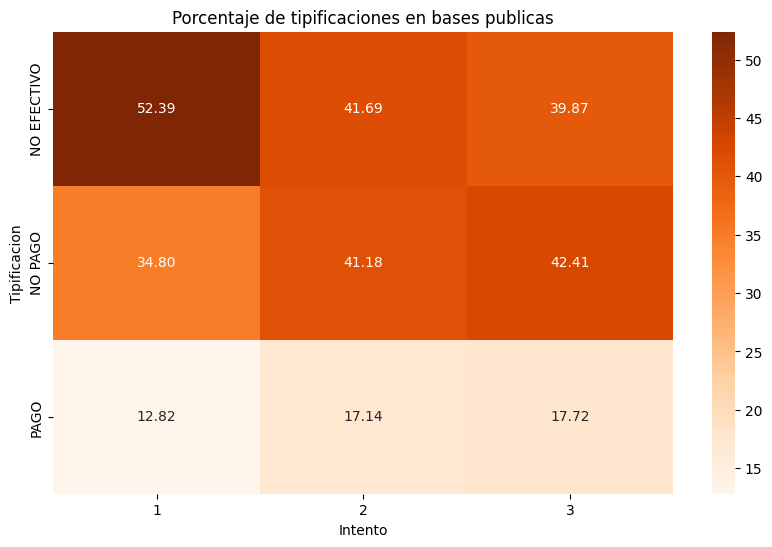

In [27]:
pivot_table_tipificaciones = pd.pivot_table(contactO_efectivo, values='Connid', index='Tipificacion', columns='Intento', aggfunc='count', fill_value=0 )
total_llamadas_intento_2 = pivot_table_tipificaciones.sum()
porcentaje_tipificaciones = (pivot_table_tipificaciones / total_llamadas_intento_2)*100
por_format_2 = porcentaje_tipificaciones.applymap(lambda x: f'{x: .2f}%')
print(por_format_2)
plt.figure(figsize=(10,6))
sns.heatmap(porcentaje_tipificaciones, annot=True, fmt=".2f", cmap="Oranges")
plt.title('Porcentaje de tipificaciones en bases publicas')
plt.xlabel('Intento')
plt.ylabel('Tipificacion')

Intento                  1        2        3
SubTipificacion                             
CONTESTA Y CUELGA   87.67%   82.21%   82.54%
FALLECIDO            0.18%    0.61%    0.00%
ILOCALIZABLE         1.10%    0.61%    0.00%
NUMERO EQUIVOCADO   11.04%   16.56%   17.46%


Text(50.7222222222222, 0.5, 'Subtipificacion')

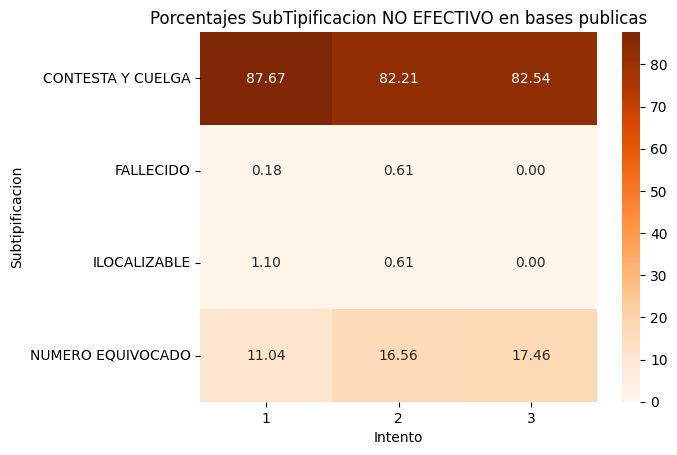

In [28]:
no_efectivo = df_2[df_2['Tipificacion']== 'NO EFECTIVO']
pivot_table_subtipificaciones = pd.pivot_table(no_efectivo, values='Connid', index='SubTipificacion', columns='Intento', aggfunc='count', fill_value=0)
total_llamadas_intento_3 = pivot_table_subtipificaciones.sum()
porcen_subtipificaciones = (pivot_table_subtipificaciones/total_llamadas_intento_3)*100
por_format_3 = porcen_subtipificaciones.applymap(lambda x: f'{x: .2f}%')
print(por_format_3)
plt.title('Porcentajes SubTipificacion NO EFECTIVO en bases publicas')
sns.heatmap(porcen_subtipificaciones, annot=True, fmt=".2f", cmap='Oranges')
plt.xlabel('Intento')
plt.ylabel('Subtipificacion')

Intento                                                   1        2        3
SubTipificacion                                                              
ASEGURADO INDICA NO HABER ADQUIRIDO ALGUNA PÓLIZA     0.83%    0.62%    0.00%
ASEGURADO INDICA NO TENER DINERO                      3.32%    2.48%    2.99%
ASEGURADO INDICA QUE SU PÓLIZA YA ESTÁ EN PROCE...    1.80%    1.86%    1.49%
ASEGURADO NO DESEA SEGUIR CON LA PÓLIZA               8.03%   14.29%   16.42%
ASEGURADO NO PASÓ LOS CANDADOS DE SEGURIDAD           0.69%    0.62%    0.00%
ASEGURADO NO QUISO PROPORCIONAR CANDADOS DE SEG...    8.73%    7.45%    8.96%
ASEGURADO NO RECONOCE ADEUDO                          1.80%    2.48%    1.49%
ASEGURADO SOLICITA HABLAR PRIMERO CON SU AGENTE      11.63%    9.32%    8.96%
ASEGURADO SOLICITA QUE LE LLAMEMOS DESPUÉS           51.11%   50.93%   46.27%
LA PERSONA QUE CONTESTA NO DESEA QUE LE VUELVAN...    0.97%    1.24%    2.99%
NO DESEA PAGAR                                        0.42%    0

Text(49.722222222222186, 0.5, 'Subtipificacion')

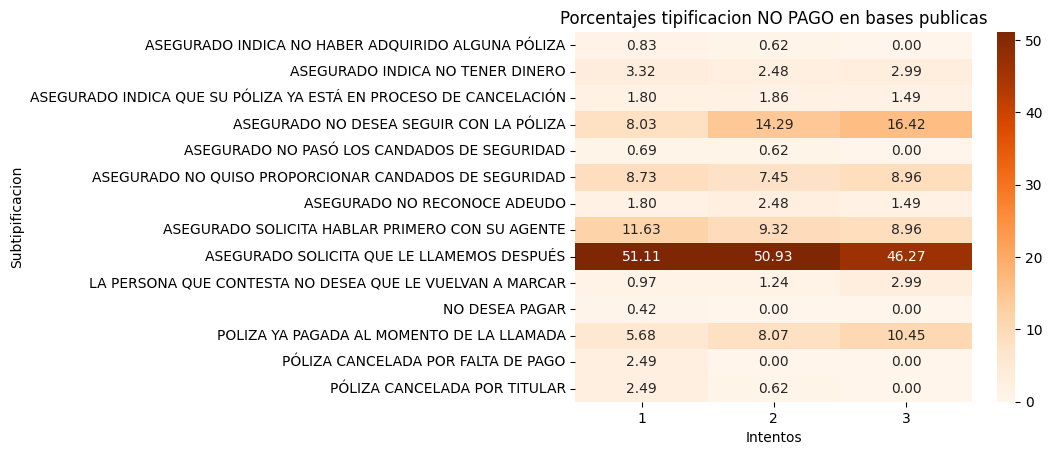

In [29]:
no_pago = df_2[df_2['Tipificacion']== 'NO PAGO']
pivot_table_subtipificaciones_1 = pd.pivot_table(no_pago, values='Connid', index='SubTipificacion', columns='Intento', aggfunc='count', fill_value=0)
total_llamadas_intento_4 = pivot_table_subtipificaciones_1.sum()
porcen_subtipificaciones_1 = (pivot_table_subtipificaciones_1/total_llamadas_intento_4)*100
por_format_4 = porcen_subtipificaciones_1.applymap(lambda x: f'{x: .2f}%')
print(por_format_4)
plt.title('Porcentajes tipificacion NO PAGO en bases publicas')
sns.heatmap(porcen_subtipificaciones_1, annot=True, fmt=".2f", cmap='Oranges')
plt.xlabel('Intentos')
plt.ylabel('Subtipificacion')

Intento                                   1        2        3
SubTipificacion                                              
CAMBIO DE CONDUCTO                    0.75%    1.49%    3.57%
COBRO EFECTIVO POR IVR                7.89%   10.45%   10.71%
COBRO EFECTIVO POR PORTAL METLIFE     0.75%    0.00%    0.00%
PROMESA DE PAGO EN BANCO             79.70%   68.66%   78.57%
PROMESA DE PAGO POR PORTAL METLIFE   10.90%   19.40%    7.14%


Text(50.7222222222222, 0.5, 'Subtipificacion')

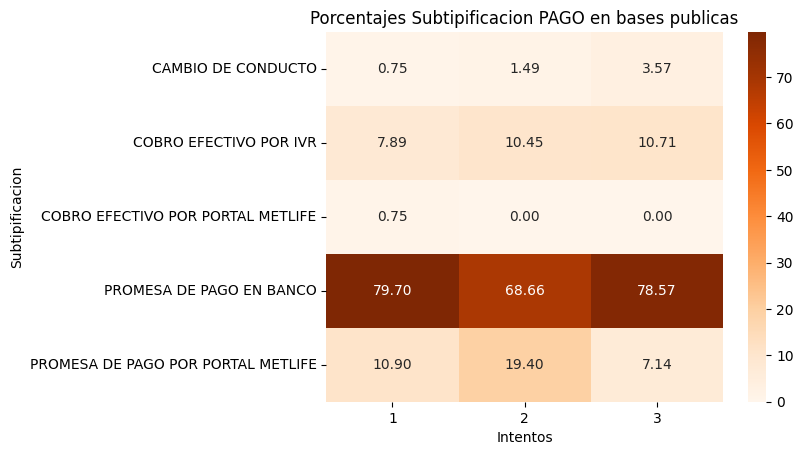

In [30]:
pago = df_2[df_2['Tipificacion']== 'PAGO']
pivot_table_subtipificaciones_2 = pd.pivot_table(pago, values='Connid', index='SubTipificacion', columns='Intento', aggfunc='count', fill_value=0)
total_llamadas_intento_5 = pivot_table_subtipificaciones_2.sum()
porcen_subtipificaciones_2 = (pivot_table_subtipificaciones_2/total_llamadas_intento_5)*100
por_format_5 = porcen_subtipificaciones_2.applymap(lambda x: f'{x: .2f}%')
print(por_format_5)
plt.title('Porcentajes Subtipificacion PAGO en bases publicas')
sns.heatmap(porcen_subtipificaciones_2, annot=True, fmt='.2f', cmap='Oranges')
plt.xlabel('Intentos')
plt.ylabel('Subtipificacion')